In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import collections 
import findspark
import pyspark
from pyspark.sql import DataFrameNaFunctions
from pyspark.sql.functions import lit 
from pyspark.sql.functions import col 
from pyspark.ml.feature import StringIndexer #label encoding
from pyspark.ml import Pipeline

sc = pyspark.SparkContext(appName="helloworld")

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [3]:
trainDF = spark.read.csv("C:/Users/Vinz/Desktop/Titanicspark/train.csv", header="true")
testDF = spark.read.csv("C:/Users/Vinz/Desktop/Titanicspark/test.csv", header="true")

In [4]:
trainDF = trainDF.withColumn('Mark', lit('train'))
testDF = (testDF.withColumn('Survived',lit(0))
                .withColumn('Mark', lit('test')))
testDF = testDF[trainDF.columns]

df = trainDF.unionAll(testDF)

In [5]:
df.createOrReplaceTempView("train")

In [6]:
df.printSchema()

root
 |-- PassengerId: string (nullable = true)
 |-- Survived: string (nullable = true)
 |-- Pclass: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SibSp: string (nullable = true)
 |-- Parch: string (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: string (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Mark: string (nullable = false)



In [7]:
def to_anytype(df, colnames, typename):
    for colname in colnames:
        df = df.withColumn("tmp", df[colname].cast(typename)) \
        .drop(colname) \
        .withColumnRenamed("tmp", colname)
    return(df)

In [8]:
intCols = ['PassengerId', 'Pclass', 'SibSp', 'Parch', 'Survived']
floatCols = ['Age', 'Fare']

df = to_anytype(df, intCols, "integer")
df = to_anytype(df, floatCols, "float")

In [9]:
df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Mark: string (nullable = false)
 |-- PassengerId: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Age: float (nullable = true)
 |-- Fare: float (nullable = true)



In [10]:
age_hist = spark.sql(
    "SELECT Age AS age, \
            count(*) AS count \
    FROM train \
    GROUP BY Age \
    ORDER BY Age")
age_hist.show(n=age_hist.count())

+----+-----+
| age|count|
+----+-----+
|null|  263|
|0.17|    1|
|0.33|    1|
|0.42|    1|
|0.67|    1|
|0.75|    3|
|0.83|    3|
|0.92|    2|
|   1|   10|
|  10|    4|
|  11|    4|
|11.5|    1|
|  12|    3|
|  13|    5|
|  14|    8|
|14.5|    2|
|  15|    6|
|  16|   19|
|  17|   20|
|  18|   39|
|18.5|    3|
|  19|   29|
|   2|   12|
|  20|   23|
|20.5|    1|
|  21|   41|
|  22|   43|
|22.5|    1|
|  23|   26|
|23.5|    1|
|  24|   47|
|24.5|    1|
|  25|   34|
|  26|   30|
|26.5|    1|
|  27|   30|
|  28|   32|
|28.5|    3|
|  29|   30|
|   3|    7|
|  30|   40|
|30.5|    2|
|  31|   23|
|  32|   24|
|32.5|    4|
|  33|   21|
|  34|   16|
|34.5|    2|
|  35|   23|
|  36|   31|
|36.5|    2|
|  37|    9|
|  38|   14|
|38.5|    1|
|  39|   20|
|   4|   10|
|  40|   18|
|40.5|    3|
|  41|   11|
|  42|   18|
|  43|    9|
|  44|   10|
|  45|   21|
|45.5|    2|
|  46|    6|
|  47|   14|
|  48|   14|
|  49|    9|
|   5|    5|
|  50|   15|
|  51|    8|
|  52|    6|
|  53|    4|
|  54|   10|

In [11]:
age_hist = spark.sql(
    "SELECT bucket_floor, \
        CONCAT(bucket_floor, ' to ', bucket_ceiling) as bucket_name, \
        count(*) as count \
     FROM ( \
        SELECT floor(Age/5.00)*5 as bucket_floor, \
            floor(Age/5.00)*5 + 5 as bucket_ceiling \
        FROM train \
     ) a \
     GROUP BY 1, 2 \
     ORDER BY 1")

age_hist.show(n=age_hist.count())

+------------+-----------+-----+
|bucket_floor|bucket_name|count|
+------------+-----------+-----+
|        null|       null|  263|
|           0|     0 to 5|   51|
|           5|    5 to 10|   31|
|          10|   10 to 15|   27|
|          15|   15 to 20|  116|
|          20|   20 to 25|  184|
|          25|   25 to 30|  160|
|          30|   30 to 35|  132|
|          35|   35 to 40|  100|
|          40|   40 to 45|   69|
|          45|   45 to 50|   66|
|          50|   50 to 55|   43|
|          55|   55 to 60|   27|
|          60|   60 to 65|   27|
|          65|   65 to 70|    5|
|          70|   70 to 75|    6|
|          75|   75 to 80|    1|
|          80|   80 to 85|    1|
+------------+-----------+-----+



In [12]:
def get_column(df, colname):
    coldata = df.rdd.map(lambda r: r[colname]).collect()
    coldata = ['None' if v is None else v for v in coldata] 
    return(coldata)

age = get_column(age_hist, "bucket_name")
count = get_column(age_hist, "count")

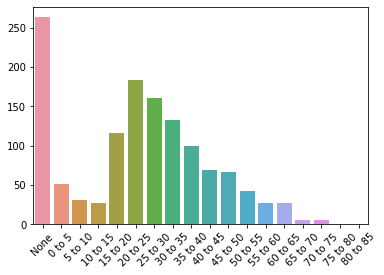

In [13]:
%matplotlib inline

barplt = sns.barplot(age, count)
for item in barplt.get_xticklabels():
    item.set_rotation(45)

In [14]:
def get_column(df, colname):
    coldata = df.rdd.map(lambda r: r[colname]).collect()
    coldata = ['None' if v is None else v for v in coldata] #replace None values
    return(coldata)

def histplot(dfname, colname, binsize):
    binsize = str(binsize)
    dfname.createOrReplaceTempView("tmpDF")
    hist_query = "SELECT bucket_floor, \
        CONCAT(bucket_floor, ' to ', bucket_ceiling) as bucket_name, \
        count(*) as count \
     FROM ( \
        SELECT floor(" + colname + "/" + binsize + ")*" + binsize + " as bucket_floor, \
            floor(" + colname + "/" + binsize + ")*" + binsize + " + " + binsize + " as bucket_ceiling \
        FROM tmpDF \
     ) a \
     GROUP BY 1, 2 \
     ORDER BY 1"
    hist_data = spark.sql(hist_query)
    xvar = get_column(hist_data, "bucket_name")
    count = get_column(hist_data, "count")
    barplt = sns.barplot(xvar, count)
    for item in barplt.get_xticklabels():
        item.set_rotation(45)
    return(barplt)

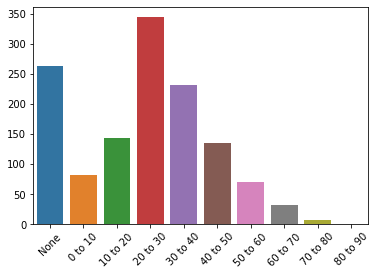

In [15]:
histplot(df, "Age", 10)

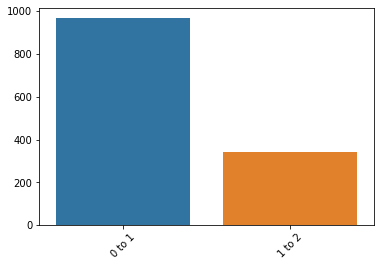

In [16]:
histplot(df, "Survived", 1)

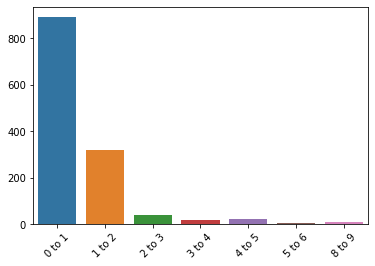

In [17]:
histplot(df, "SibSp", 1)

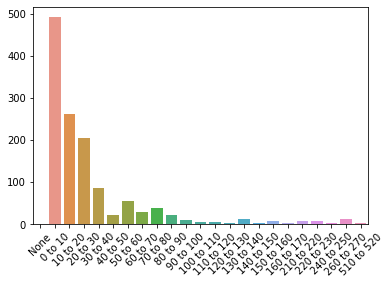

In [18]:
histplot(df, "Fare", 10)

In [19]:
def histplot_s(df, colname):
    xvar = get_column(df, colname)
    counter = collections.Counter(xvar)
    barplt = sns.barplot(list(counter.keys()), list(counter.values()))
    for item in barplt.get_xticklabels():
        item.set_rotation(45)
    return(barplt)

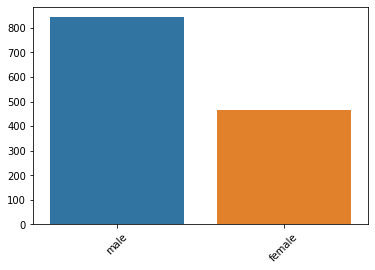

In [20]:
histplot_s(df, "Sex")

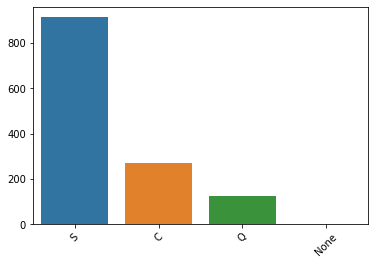

In [21]:
histplot_s(df, "Embarked")

In [22]:
df.corr("Age", "Fare")

0.21349686667435705

In [23]:
df.corr("Age", "SibSp")

-0.13446462318917687

In [24]:
df.corr("Age", "Parch")

-0.039940130829688975

In [25]:
df_num = df['PassengerId','Pclass','SibSp','Parch','Survived','Age','Fare']

In [26]:
df_num.show(5)

+-----------+------+-----+-----+--------+----+-------+
|PassengerId|Pclass|SibSp|Parch|Survived| Age|   Fare|
+-----------+------+-----+-----+--------+----+-------+
|          1|     3|    1|    0|       0|22.0|   7.25|
|          2|     1|    1|    0|       1|38.0|71.2833|
|          3|     3|    0|    0|       1|26.0|  7.925|
|          4|     1|    1|    0|       1|35.0|   53.1|
|          5|     3|    0|    0|       0|35.0|   8.05|
+-----------+------+-----+-----+--------+----+-------+
only showing top 5 rows



In [27]:
numVars = ['Survived','Age','SibSp','Parch','Fare']
stringVars = ['Cabin', 'Embarked', 'Pclass', 'Sex']

def countNull(df,var):
    return df.where(df[var].isNull()).count()

def countEmptyString(df,var):
    return df[df[var].isin("")].count()

def countZero(df,var):
    return df[df[var].isin(0)].count()

In [28]:
missing = {var: countNull(df,var) for var in df.columns}
missing

{'Name': 0,
 'Sex': 0,
 'Ticket': 0,
 'Cabin': 1014,
 'Embarked': 2,
 'Mark': 0,
 'PassengerId': 0,
 'Pclass': 0,
 'SibSp': 0,
 'Parch': 0,
 'Survived': 0,
 'Age': 263,
 'Fare': 1}

In [29]:
missing = {var: countEmptyString(df, var) for var in df.columns}
missing

{'Name': 0,
 'Sex': 0,
 'Ticket': 0,
 'Cabin': 0,
 'Embarked': 0,
 'Mark': 0,
 'PassengerId': 0,
 'Pclass': 0,
 'SibSp': 0,
 'Parch': 0,
 'Survived': 0,
 'Age': 0,
 'Fare': 0}

In [30]:
missing = {var: countZero(df, var) for var in df.columns}
missing

{'Name': 0,
 'Sex': 0,
 'Ticket': 0,
 'Cabin': 0,
 'Embarked': 0,
 'Mark': 0,
 'PassengerId': 0,
 'Pclass': 0,
 'SibSp': 891,
 'Parch': 1002,
 'Survived': 967,
 'Age': 0,
 'Fare': 17}

In [31]:
df

DataFrame[Name: string, Sex: string, Ticket: string, Cabin: string, Embarked: string, Mark: string, PassengerId: int, Pclass: int, SibSp: int, Parch: int, Survived: int, Age: float, Fare: float]

In [32]:
df_num.take(5)

[Row(PassengerId=1, Pclass=3, SibSp=1, Parch=0, Survived=0, Age=22.0, Fare=7.25),
 Row(PassengerId=2, Pclass=1, SibSp=1, Parch=0, Survived=1, Age=38.0, Fare=71.2833023071289),
 Row(PassengerId=3, Pclass=3, SibSp=0, Parch=0, Survived=1, Age=26.0, Fare=7.925000190734863),
 Row(PassengerId=4, Pclass=1, SibSp=1, Parch=0, Survived=1, Age=35.0, Fare=53.099998474121094),
 Row(PassengerId=5, Pclass=3, SibSp=0, Parch=0, Survived=0, Age=35.0, Fare=8.050000190734863)]

In [33]:
age_mean = df.groupBy().mean('Age').first()

In [34]:
age_mean = df.groupby(['Mark']).mean('Age').first()

In [35]:
age_mean

Row(Mark='train', avg(Age)=29.69911764704046)

In [36]:
age_mean = df.groupby(['Mark']).mean('Age').take(2)

In [37]:
age_mean

[Row(Mark='train', avg(Age)=29.69911764704046),
 Row(Mark='test', avg(Age)=30.272590361490668)]

In [38]:
Fare_mean = df.groupby(['Mark']).mean('Fare').take(2)

In [39]:
Fare_mean

[Row(Mark='train', avg(Fare)=32.20420804114722),
 Row(Mark='test', avg(Fare)=35.62718864996656)]

In [40]:
age_mean[1][0]

'test'

In [41]:
age_mean = df.groupby(['Mark']).mean('Age').take(2)
age_mean

[Row(Mark='train', avg(Age)=29.69911764704046),
 Row(Mark='test', avg(Age)=30.272590361490668)]

In [42]:
age_mean_train = age_mean[0][1]
age_mean_train

29.69911764704046

In [43]:
age_mean_test = age_mean[1][1]
age_mean_test

30.272590361490668

In [44]:
Fare_mean = df.groupby(['Mark']).mean('Fare').take(2)
Fare_mean

[Row(Mark='train', avg(Fare)=32.20420804114722),
 Row(Mark='test', avg(Fare)=35.62718864996656)]

In [45]:
fare_mean_train = Fare_mean[0][1]
fare_mean_train

32.20420804114722

In [46]:
fare_mean_test = Fare_mean[1][1]
fare_mean_test

35.62718864996656

In [47]:
train1 = df.where(df.Mark=='train')
test1 = df.where(df.Mark=='test')

In [48]:
test1.show(5)

+--------------------+------+-------+-----+--------+----+-----------+------+-----+-----+--------+----+-------+
|                Name|   Sex| Ticket|Cabin|Embarked|Mark|PassengerId|Pclass|SibSp|Parch|Survived| Age|   Fare|
+--------------------+------+-------+-----+--------+----+-----------+------+-----+-----+--------+----+-------+
|    Kelly, Mr. James|  male| 330911| null|       Q|test|        892|     3|    0|    0|       0|34.5| 7.8292|
|Wilkes, Mrs. Jame...|female| 363272| null|       S|test|        893|     3|    1|    0|       0|47.0|    7.0|
|Myles, Mr. Thomas...|  male| 240276| null|       Q|test|        894|     2|    0|    0|       0|62.0| 9.6875|
|    Wirz, Mr. Albert|  male| 315154| null|       S|test|        895|     3|    0|    0|       0|27.0| 8.6625|
|Hirvonen, Mrs. Al...|female|3101298| null|       S|test|        896|     3|    1|    1|       0|22.0|12.2875|
+--------------------+------+-------+-----+--------+----+-----------+------+-----+-----+--------+----+-------+
o

In [49]:
df1 = train1.na.fill({'Age':age_mean_train,'Fare':fare_mean_train})
df2 = test1.na.fill({'Age':age_mean_test,'Fare':fare_mean_test})

In [50]:
df_updated = df1.unionAll(df2)

In [51]:
df = df_updated

In [52]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
 
getTitle = udf(lambda name: name.split('.')[0].strip(), StringType())
df = df.withColumn('Title', getTitle(df['Name']))
 
df.select('Name','Title').show(5)

+--------------------+---------------+
|                Name|          Title|
+--------------------+---------------+
|Braund, Mr. Owen ...|     Braund, Mr|
|Cumings, Mrs. Joh...|   Cumings, Mrs|
|Heikkinen, Miss. ...|Heikkinen, Miss|
|Futrelle, Mrs. Ja...|  Futrelle, Mrs|
|Allen, Mr. Willia...|      Allen, Mr|
+--------------------+---------------+
only showing top 5 rows



In [53]:
getTitle = udf(lambda name: name.split('.')[0].split(',')[1].strip(), StringType())
df = df.withColumn('Title', getTitle(df['Name']))
 
df.select('Name','Title').show(5)

+--------------------+-----+
|                Name|Title|
+--------------------+-----+
|Braund, Mr. Owen ...|   Mr|
|Cumings, Mrs. Joh...|  Mrs|
|Heikkinen, Miss. ...| Miss|
|Futrelle, Mrs. Ja...|  Mrs|
|Allen, Mr. Willia...|   Mr|
+--------------------+-----+
only showing top 5 rows



In [54]:
catVars = ['Pclass','Sex','Embarked','Title']
 
si = StringIndexer(inputCol = 'Sex', outputCol = 'Sex_indexed')
df_indexed = si.fit(df).transform(df).drop('Sex').withColumnRenamed('Sex_indexed','Sex')

In [55]:
df_indexed.show(5)

+--------------------+----------------+-----+--------+-----+-----------+------+-----+-----+--------+----+-------+-----+---+
|                Name|          Ticket|Cabin|Embarked| Mark|PassengerId|Pclass|SibSp|Parch|Survived| Age|   Fare|Title|Sex|
+--------------------+----------------+-----+--------+-----+-----------+------+-----+-----+--------+----+-------+-----+---+
|Braund, Mr. Owen ...|       A/5 21171| null|       S|train|          1|     3|    1|    0|       0|22.0|   7.25|   Mr|0.0|
|Cumings, Mrs. Joh...|        PC 17599|  C85|       C|train|          2|     1|    1|    0|       1|38.0|71.2833|  Mrs|1.0|
|Heikkinen, Miss. ...|STON/O2. 3101282| null|       S|train|          3|     3|    0|    0|       1|26.0|  7.925| Miss|1.0|
|Futrelle, Mrs. Ja...|          113803| C123|       S|train|          4|     1|    1|    0|       1|35.0|   53.1|  Mrs|1.0|
|Allen, Mr. Willia...|          373450| null|       S|train|          5|     3|    0|    0|       0|35.0|   8.05|   Mr|0.0|
+-------

In [56]:
def indexer(df, col):
    si = StringIndexer(inputCol = col, outputCol = col+'_indexed').fit(df)
    return si
 
indexers = [indexer(df, col) for col in catVars]

In [57]:
pipeline = Pipeline(stages = indexers)
df_indexed = pipeline.fit(df).transform(df)
 
df_indexed.select('Embarked','Embarked_indexed').show(3)

+--------+----------------+
|Embarked|Embarked_indexed|
+--------+----------------+
|       S|             0.0|
|       C|             1.0|
|       S|             0.0|
+--------+----------------+
only showing top 3 rows



In [58]:
from pyspark.sql import Row
from pyspark.ml.linalg import DenseVector

In [59]:
catVarsIndexed = [i + '_indexed' for i in catVars]
catVarsIndexed

['Pclass_indexed', 'Sex_indexed', 'Embarked_indexed', 'Title_indexed']

In [60]:
featuresCol = numVars + catVarsIndexed
featuresCol

['Survived',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Pclass_indexed',
 'Sex_indexed',
 'Embarked_indexed',
 'Title_indexed']

In [61]:
featuresCol.remove('Survived')
featuresCol

['Age',
 'SibSp',
 'Parch',
 'Fare',
 'Pclass_indexed',
 'Sex_indexed',
 'Embarked_indexed',
 'Title_indexed']

In [62]:
labelCol = ['Mark','Survived']
labelCol

['Mark', 'Survived']

In [63]:
row = Row('mark','label','features') 
row

<Row(mark, label, features)>

In [64]:
df_indexed = df_indexed[labelCol + featuresCol]
df_indexed

DataFrame[Mark: string, Survived: int, Age: float, SibSp: int, Parch: int, Fare: float, Pclass_indexed: double, Sex_indexed: double, Embarked_indexed: double, Title_indexed: double]

In [65]:
lf = df_indexed.rdd.map(lambda r: (row(r[0], r[1],DenseVector(r[2:])))).toDF()
lf.show()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 209.0 failed 1 times, most recent failure: Lost task 0.0 in stage 209.0 (TID 4569, localhost, executor driver): org.apache.spark.SparkException: Failed to execute user defined function($anonfun$9: (string) => double)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$12$$anon$1.hasNext(WholeStageCodegenExec.scala:631)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.next(SerDeUtil.scala:156)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.next(SerDeUtil.scala:148)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.foreach(SerDeUtil.scala:148)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:223)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:444)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread$$anonfun$run$1.apply(PythonRunner.scala:250)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1992)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:173)
Caused by: org.apache.spark.SparkException: StringIndexer encountered NULL value. To handle or skip NULLS, try setting StringIndexer.handleInvalid.
	at org.apache.spark.ml.feature.StringIndexerModel$$anonfun$9.apply(StringIndexer.scala:251)
	at org.apache.spark.ml.feature.StringIndexerModel$$anonfun$9.apply(StringIndexer.scala:246)
	... 13 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1661)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1649)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1648)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1648)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1882)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1820)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function($anonfun$9: (string) => double)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$12$$anon$1.hasNext(WholeStageCodegenExec.scala:631)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.next(SerDeUtil.scala:156)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.next(SerDeUtil.scala:148)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.foreach(SerDeUtil.scala:148)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:223)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:444)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread$$anonfun$run$1.apply(PythonRunner.scala:250)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1992)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:173)
Caused by: org.apache.spark.SparkException: StringIndexer encountered NULL value. To handle or skip NULLS, try setting StringIndexer.handleInvalid.
	at org.apache.spark.ml.feature.StringIndexerModel$$anonfun$9.apply(StringIndexer.scala:251)
	at org.apache.spark.ml.feature.StringIndexerModel$$anonfun$9.apply(StringIndexer.scala:246)
	... 13 more


In [ ]:
lf = StringIndexer(inputCol = 'label', outputCol='index').fit(lf).transform(lf)
 
lf.show(3)

In [ ]:
train = lf.where(lf.mark =='train')
test = lf.where(lf.mark =='test')

In [ ]:
type(train)
train.show(5)

In [ ]:
train, validate = train.randomSplit([0.7,0.3], seed =121)

In [ ]:
print('Train Data Number of Row: '+ str(train.count()))
print('Validate Data Number of Row: '+ str(validate.count()))
print('Test Data Number of Row: '+ str(test.count()))

In [ ]:
from pyspark.ml.classification import LogisticRegression
 
lr = LogisticRegression(maxIter = 100, regParam = 0.05, labelCol='index').fit(train)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
 
def testModel(model, validate = validate):
    pred = model.transform(validate)
    evaluator = BinaryClassificationEvaluator(labelCol = 'index')
    return evaluator.evaluate(pred)

In [ ]:
print('AUC ROC of Logistic Regression model is: ' + str(testModel(lr)))

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
 
dt = DecisionTreeClassifier(maxDepth = 3, labelCol ='index').fit(train)
rf = RandomForestClassifier(numTrees = 100, labelCol = 'index').fit(train)
gbt = GBTClassifier(maxIter = 10, labelCol = 'index').fit(train)

In [ ]:
models = {'LogisticRegression':lr,
          'DecistionTree':dt,
          'RandomForest':rf}
 
modelPerf = {k:testModel(v) for k,v in models.items()}
print(modelPerf)

In [ ]:
model_acc(gbt)